# Comparing two normal distributions (with random effects)

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [2]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## The story

![traffic](..\images\traffic.jpg)

> Let's image that you have collected some data on highway driving. Some people were driving manually, whereas some others were using adaptive cruise control (ACC). You want to investigate if there is any difference in speed between manual driving and driving with ACC. The hypothesis is that ACC, by automating the longitudinal control of the car, will have an impact on the speed people travel at.

## Generate artificial data

In [4]:
n_driving_mode = 2
n_drivers = 15
n_samples_per_driving_mode = 25

between_driver_sd = np.array([0.5, 0.5])

In [5]:
drivers = ['Driver_{:02}'.format(i+1) for i in range(n_drivers)]
drivers

['Driver_01',
 'Driver_02',
 'Driver_03',
 'Driver_04',
 'Driver_05',
 'Driver_06',
 'Driver_07',
 'Driver_08',
 'Driver_09',
 'Driver_10',
 'Driver_11',
 'Driver_12',
 'Driver_13',
 'Driver_14',
 'Driver_15']

In [6]:
mu_fixed_effect = np.array([100, 100])
sd_fixed_effect = np.array([2, 0.5])

In [7]:
# I draw the mu for each driver
# I draw the mu for each driver
mu_driver = np.random.normal(loc=mu_fixed_effect, scale=between_driver_sd, size=(n_drivers, n_driving_mode))
mu_driver.mean(axis=0), mu_driver.std(axis=0)

(array([100.06913141,  99.95692165]), array([0.58238943, 0.629723  ]))

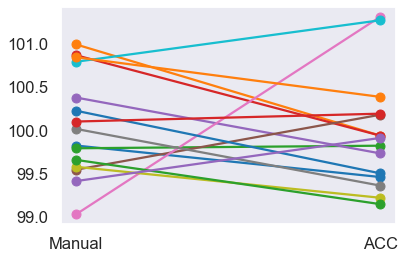

In [8]:
plt.plot(np.array([0, 1]), mu_driver.T, marker='o');
plt.xticks([0, 1], (['Manual', 'ACC']))
pass

In [9]:
# I draw the sd for each driver
sd_driver = np.random.normal(loc=sd_fixed_effect, scale=between_driver_sd, size=(n_drivers, n_driving_mode))
sd_driver = np.abs(sd_driver)
sd_driver.mean(axis=0), sd_driver.std(axis=0)

(array([1.87174215, 0.66941988]), array([0.46409738, 0.4680396 ]))

In [10]:
#draw observations around the mean for each driver and each driving mode
obs = np.random.normal(loc=mu_driver, scale=sd_driver, size=(n_samples_per_driving_mode, n_drivers, n_driving_mode))
obs.shape

(25, 15, 2)

In [11]:
data = pd.DataFrame(
        {
            'speed':np.concatenate((obs[:, :, 0].flatten(order='C'), obs[:, :, 1].flatten(order='C'))),
            'driver':np.tile(drivers, reps=n_samples_per_driving_mode*n_driving_mode),
            'ACC_active':np.concatenate((np.zeros(n_samples_per_driving_mode*n_drivers), np.ones(n_samples_per_driving_mode*n_drivers)))
        }

)

In [12]:
data['ACC_active'] = data['ACC_active'].astype('int')
data['driver'] = data['driver'].astype('category')

In [13]:
data.head()

,speed,driver,ACC_active
0,102.247683,Driver_01,0
1,101.479724,Driver_02,0
2,97.924662,Driver_03,0
3,94.413885,Driver_04,0
4,98.139225,Driver_05,0


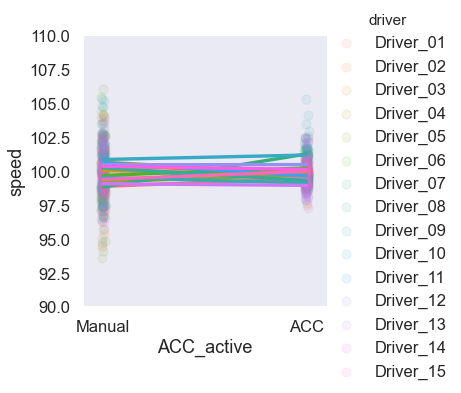

In [14]:
sns.lmplot(x='ACC_active', y='speed', hue='driver', data=data, ci=None, x_jitter=0.01, scatter_kws=dict(alpha=0.1))
plt.xlim((-0.1, 1.1))
plt.ylim((90, 110))
plt.xticks([0, 1], (['Manual', 'ACC']))

pass

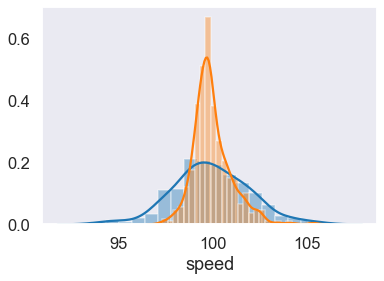

In [15]:
sns.distplot(data.loc[data['ACC_active']==0, 'speed'])
sns.distplot(data.loc[data['ACC_active']==1, 'speed'])

pass

In [16]:
data.groupby('ACC_active').agg(['mean', 'std'])

speed          
                 mean       std
ACC_active                     
0           99.903666  2.019212
1           99.953667  1.023341

A first look suggests that manual driving has higher speed variability than ACC driving. Moreover, it seems that, on average, the speed is not much different between manual driving and ACC driving. A possible explanation is that the activation of ACC reduce the human variability in maintaining the speed and the headway to the lead vehicle. Each driver, however, shows a slightly different effect of ACC on their driving behavior. Some drivers lowered their speed, whereas some other increased theirs.

We will estimate the difference in average speed and variability with Bayesian modelling. Thanks to the Bayesian method we will also obtain the uncertainty of the estimation. 

## Bayesian modelling

In [17]:
X = patsy.dmatrix('1 + ACC_active', data=data)
Z_intercept = patsy.dmatrix('0 + driver', data=data)
Z_slope = patsy.dmatrix('0 + driver:ACC_active', data=data)
X.shape, Z_intercept.shape, Z_slope.shape

((750, 2), (750, 15), (750, 15))

In [18]:
data.head()

,speed,driver,ACC_active
0,102.247683,Driver_01,0
1,101.479724,Driver_02,0
2,97.924662,Driver_03,0
3,94.413885,Driver_04,0
4,98.139225,Driver_05,0


In [19]:
# Sampler settings
BURNIN=1000
TUNE=1000
SAMPLES=1000

### Build the model

In [20]:
with pm.Model() as model:
    
    ## 'mu' Fixed effect
    beta_mu_intercept = pm.Normal('beta_mu_intercept', mu=data['speed'].mean(), sd=5)
    beta_mu_slope = pm.Normal('beta_mu_slope', mu=0, sd=5)
    beta_mu = tt.stack(beta_mu_intercept, beta_mu_slope)
    
    ## 'mu' Random effect
    # intercept
    gamma_mu_intercept_sd = pm.HalfNormal('gamma_mu_intercept_sd', sd=5)
    gamma_mu_intercept_raw = pm.Normal('gamma_mu_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_mu_intercept = pm.Deterministic('gamma_mu_intercept', gamma_mu_intercept_raw * gamma_mu_intercept_sd)
    
    # slope
    gamma_mu_slope_sd = pm.HalfNormal('gamma_mu_slope_sd', sd=5)
    gamma_mu_slope_raw = pm.Normal('gamma_mu_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_mu_slope = pm.Deterministic('gamma_mu_slope', gamma_mu_slope_raw * gamma_mu_slope_sd)  
        
    mu = tt.dot(np.asarray(X), beta_mu) + \
         tt.dot(np.asarray(Z_intercept), gamma_mu_intercept) + \
         tt.dot(np.asarray(Z_slope), gamma_mu_slope)

    ## 'sd' Fixed effect
    beta_sd_intercept = pm.Normal('beta_sd_intercept', mu=0, sd=2)
    beta_sd_slope = pm.Normal('beta_sd_slope', mu=0, sd=2)
    beta_sd = tt.stack(beta_sd_intercept, beta_sd_slope)
    
    ## 'sd' Random effect
    # intercept
    gamma_sd_intercept_sd = pm.HalfNormal('gamma_sd_intercept_sd', sd=2)
    gamma_sd_intercept_raw = pm.Normal('gamma_sd_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_sd_intercept = pm.Deterministic('gamma_sd_intercept', gamma_sd_intercept_raw * gamma_sd_intercept_sd)
    
    # slope
    gamma_sd_slope_sd = pm.HalfNormal('gamma_sd_slope_sd', sd=2)
    gamma_sd_slope_raw = pm.Normal('gamma_sd_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_sd_slope = pm.Deterministic('gamma_sd_slope', gamma_sd_slope_raw * gamma_sd_slope_sd)
    
    sd = tt.sqrt(tt.exp(tt.dot(np.asarray(X), beta_sd))) + \
         tt.sqrt(tt.exp(tt.dot(np.asarray(Z_intercept), gamma_sd_intercept))) + \
         tt.sqrt(tt.exp(tt.dot(np.asarray(Z_slope), gamma_sd_slope)))
    
    ## Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=data['speed'].values)

In [21]:
model.check_test_point()

beta_mu_intercept                -2.53
beta_mu_slope                    -2.53
gamma_mu_intercept_sd_log__      -0.77
gamma_mu_intercept_raw          -13.78
gamma_mu_slope_sd_log__          -0.77
gamma_mu_slope_raw              -13.78
beta_sd_intercept                -1.61
beta_sd_slope                    -1.61
gamma_sd_intercept_sd_log__      -0.77
gamma_sd_intercept_raw          -13.78
gamma_sd_slope_sd_log__          -0.77
gamma_sd_slope_raw              -13.78
likelihood                    -1619.66
Name: Log-probability of test_point, dtype: float64

In [22]:
# Download graphviz to run
# pm.model_to_graphviz(model)

### Sample from the model

In [26]:
# Too slow to run
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED)

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma_sd_slope_raw, gamma_sd_slope_sd, gamma_sd_intercept_raw, gamma_sd_intercept_sd, beta_sd_slope, beta_sd_intercept, gamma_mu_slope_raw, gamma_mu_slope_sd, gamma_mu_intercept_raw, gamma_mu_intercept_sd, beta_mu_slope, beta_mu_intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10175 seconds.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### Diagnose the sampling

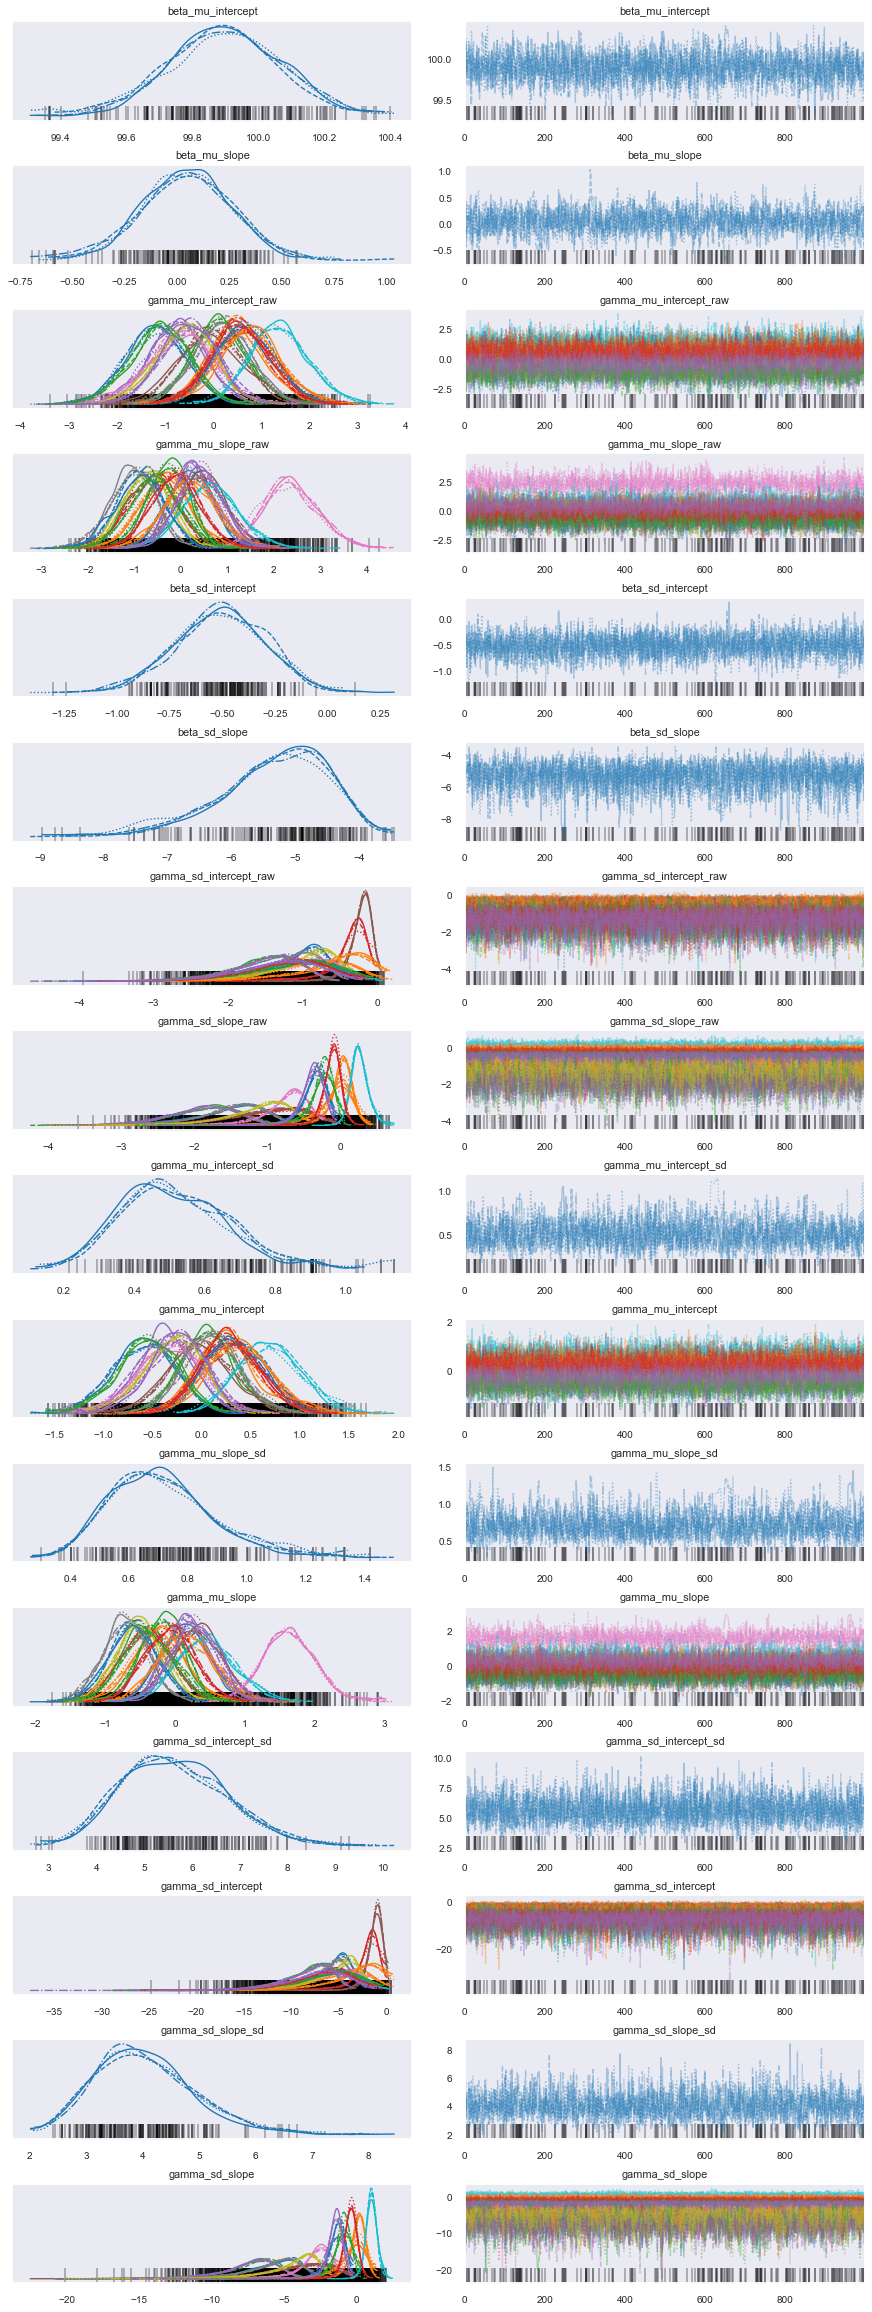

In [27]:
pm.traceplot(trace);

### Summarize the posterior density

In [28]:
pm.summary(trace).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_mu_intercept,99.90,0.17,99.58,100.23,0.00,0.00,1273.0,1273.0,1350.0,887.0,1.0
beta_mu_slope,0.05,0.22,-0.36,0.45,0.01,0.00,1327.0,972.0,1353.0,1127.0,1.0
gamma_mu_intercept_raw[0],-1.19,0.62,-2.36,-0.04,0.01,0.01,2246.0,2075.0,2240.0,2299.0,1.0
gamma_mu_intercept_raw[1],0.51,0.61,-0.59,1.70,0.01,0.01,3134.0,2677.0,3125.0,2790.0,1.0
gamma_mu_intercept_raw[2],0.14,0.60,-0.98,1.27,0.01,0.01,2967.0,1508.0,2955.0,2328.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
gamma_sd_slope[10],-1.48,0.86,-2.75,-0.34,0.03,0.02,1091.0,1043.0,1715.0,1039.0,1.0
gamma_sd_slope[11],-0.54,1.43,-2.98,1.12,0.05,0.04,845.0,803.0,1473.0,824.0,1.0
gamma_sd_slope[12],-1.08,0.93,-2.49,-0.01,0.03,0.02,1179.0,1025.0,2205.0,1277.0,1.0
gamma_sd_slope[13],-0.46,0.48,-1.26,0.35,0.01,0.01,1206.0,887.0,1888.0,1238.0,1.0


## Statistical inference

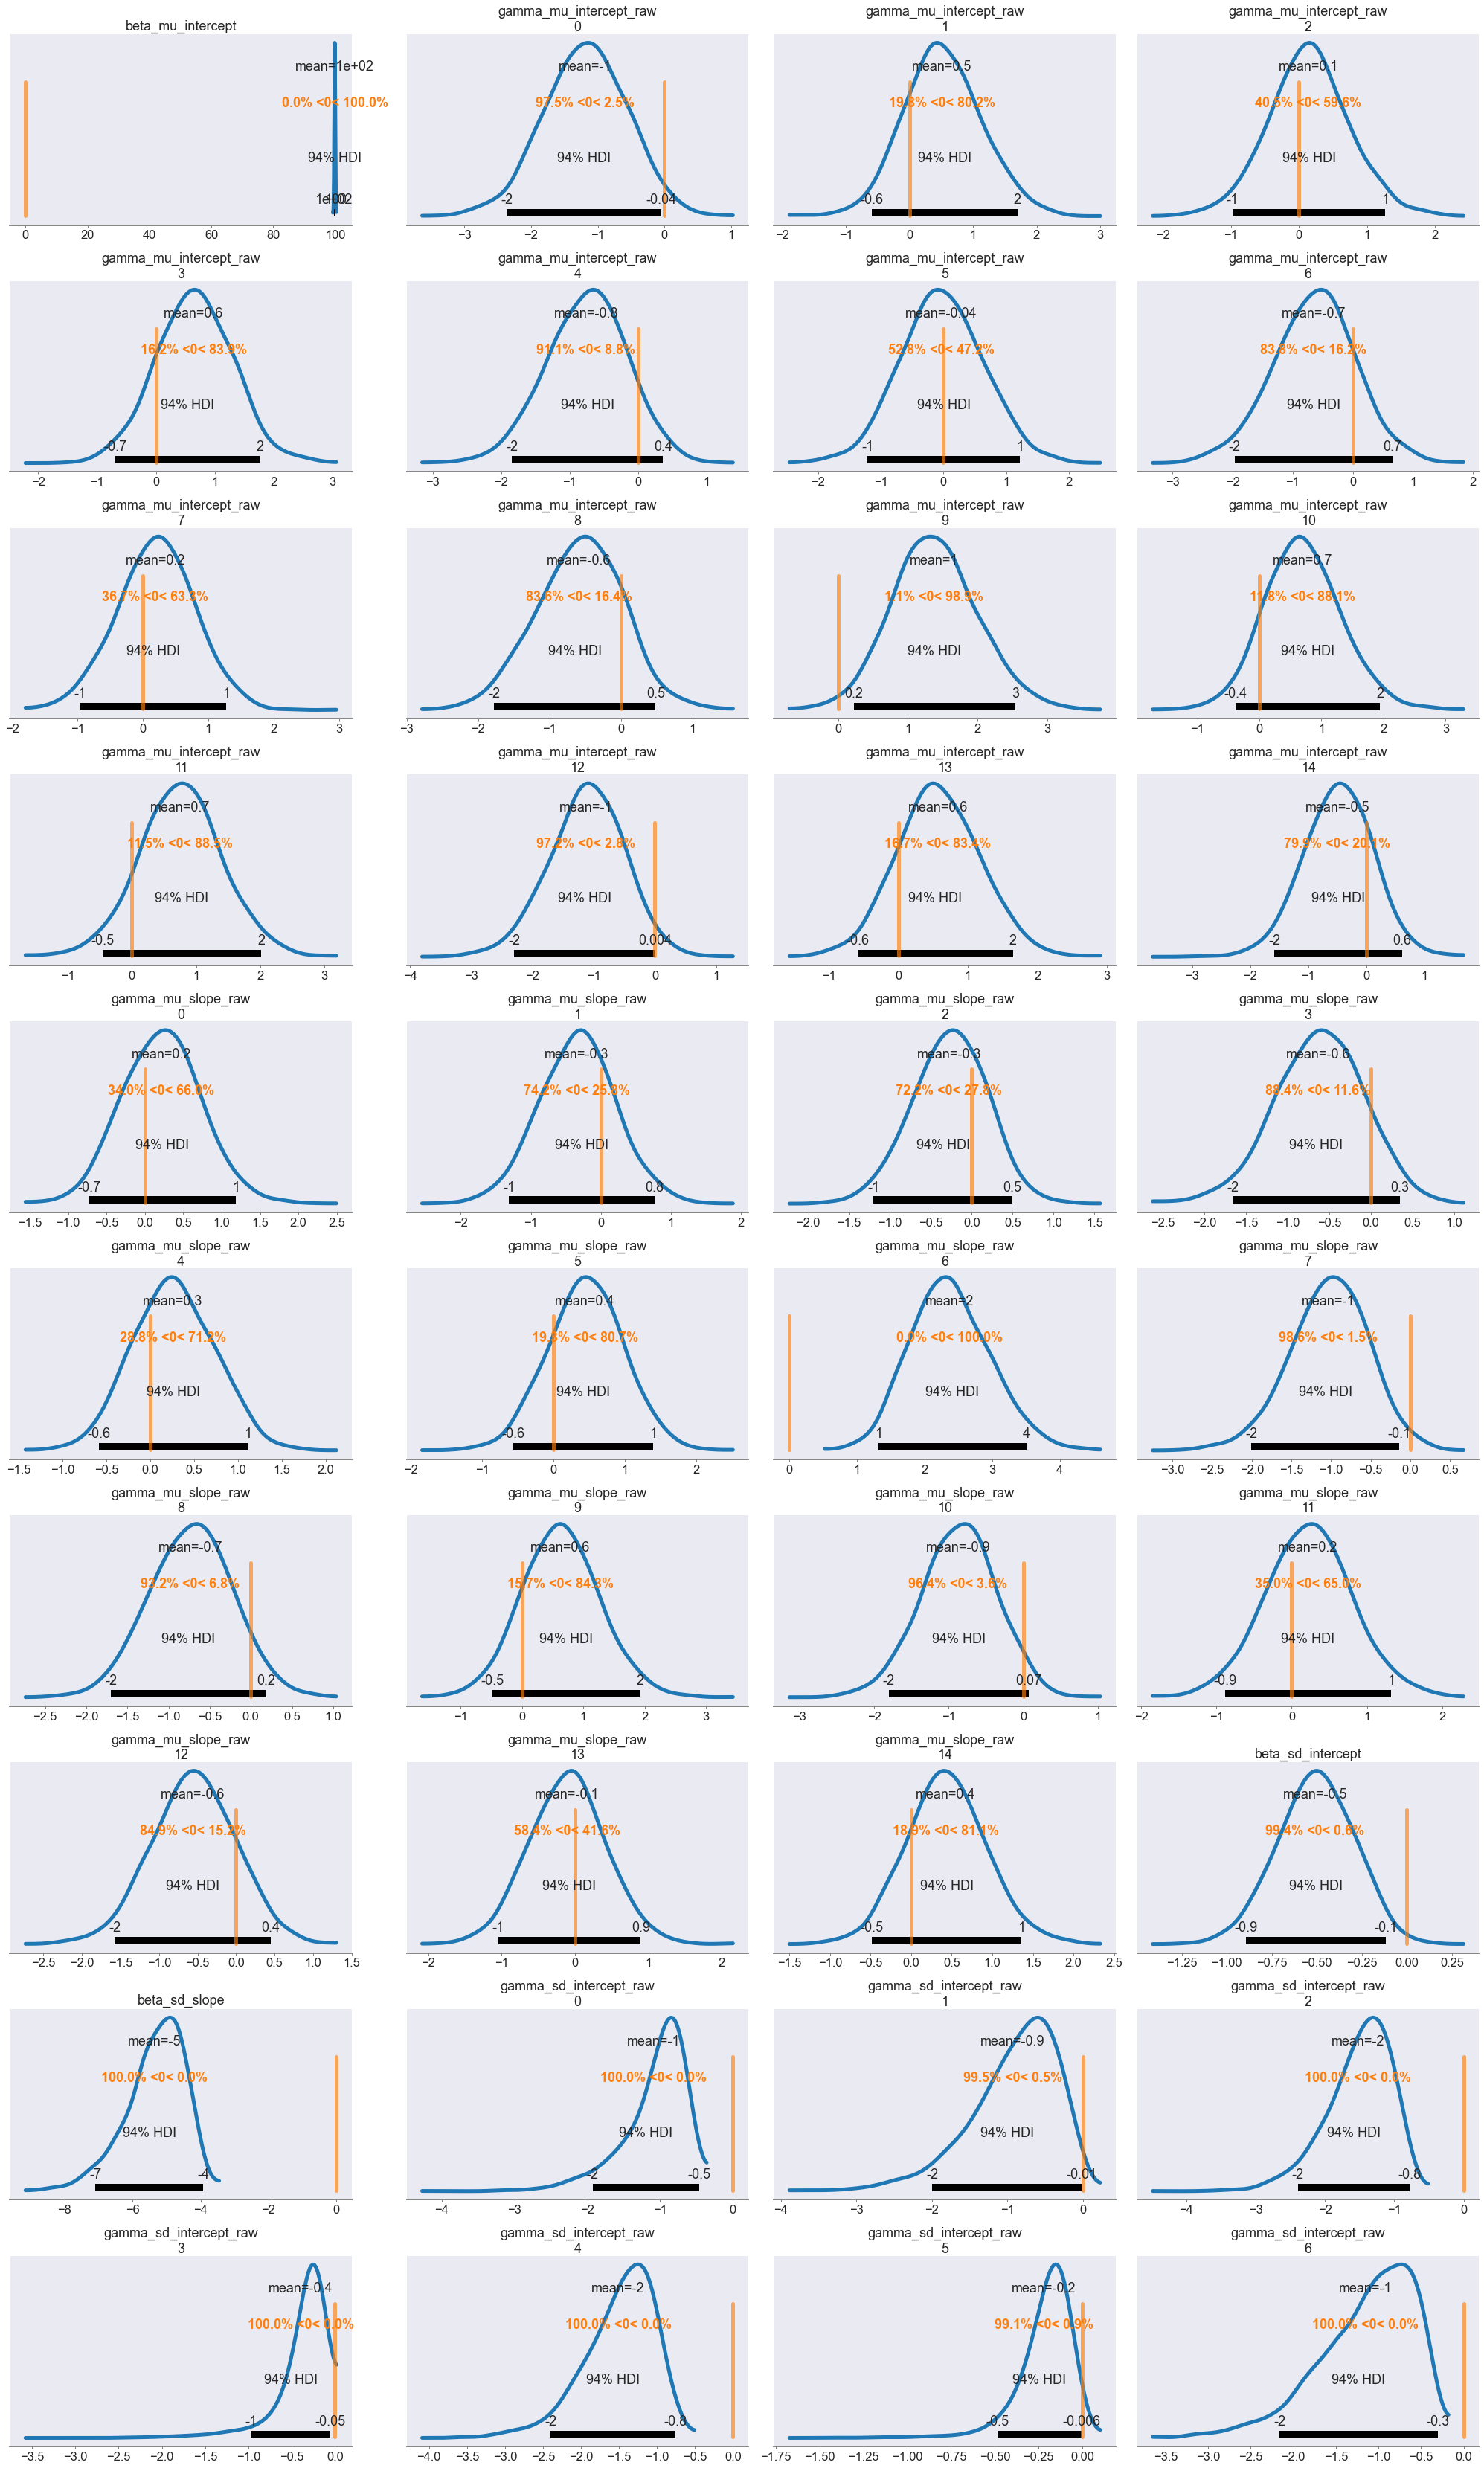

In [31]:
pm.plot_posterior(trace, varnames=['beta_mu_intercept','gamma_mu_intercept_raw',
                                   'gamma_mu_slope_raw','beta_sd_intercept',
                                   'beta_sd_slope', 'gamma_sd_intercept_raw', 
                                   'gamma_sd_slope_raw'], ref_val=0, round_to=1, lw=5);